# LAB 05 Assigment

Dominik Breksa (dominikbreksa@student.agh.edu.pl)

In [1]:
import numpy as np;import matplotlib.pyplot as plt;from open_atmos_jupyter_utils import show_plot;from functools import partial;plt.rcParams['axes.grid'] = True

### Code definitions copied from notebook provided at the laboratory classes

Minor changes present to make the code easier to comprehend.

In [2]:
def initial_conditions(x, x0, a, sigma):
    return a * np.exp(-(x - x0) ** 2 / 2 / sigma ** 2)

def solve_analytic(initial_condition, u, x, t):
    return initial_condition(x - u * t)

In [3]:
class Shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

one = Shift(add=1, sub=1)
hlf = Shift(add=0, sub=1)

In [4]:
def f(psi_l, psi_r, c):
    return .5 * (c + abs(c)) * psi_l + \
           .5 * (c - abs(c)) * psi_r

def upwind(psi, i, c):
    psi[i] = psi[i] - (
            f(psi[i], psi[i + one], c[i + hlf]) -
            f(psi[i - one], psi[i], c[i - hlf])
    )

def solve_upwind(*, nt: int, c: np.ndarray, psi: np.ndarray):
    assert np.all(np.abs(c) <= 1.), 'All C elements must be less than one'

    for _ in range(nt):
        upwind(psi, slice(1, len(c)), c)

    return psi

In [5]:
NT = 50
T_MAX = 150
DT = T_MAX / NT

In [6]:
NX = 50
X, DX = np.linspace(-100, 320, NX, retstep=True)

In [7]:
U = 1.25
C = np.full(NX - 1, U * DT / DX)

In [8]:
INITIAL_CONDITIONS = partial(initial_conditions, x0=0., a=1., sigma=20.)
ANALYTIC_SOLUTION = partial(solve_analytic, INITIAL_CONDITIONS, U)

### Code implementing multiple iterations

Here I present the implementation of MPDATA algorithm with corrective iterations:

- ***corrective_c*** — Function that corrects the courant number, with safety guard not to divide by 0 as advised at the laboratory classes.
- ***solve_mpdata*** — Function that implements the iteration of the corrective anti-diffusive velocity of mpdata algorithm. Additionally, added asserts guarding the Courant number array elements to guarantee that the algorithm will behave stable.

In [9]:
def corrective_c(c: np.ndarray, i: slice, psi: np.ndarray):
    denominator = psi[i] + psi[i - one]
    denominator = np.where(np.isclose(denominator, 0.), 0., (psi[i] - psi[i - one]) / denominator)
    return (np.abs(c[i - hlf]) - c[i - hlf] ** 2) * denominator

In [10]:
def solve_mpdata(*, nt: int, c: np.ndarray, psi: np.ndarray, iterations):
    assert np.all(np.abs(c) < 1.), 'All C elements must be less than one'
    i_ext = slice(1, len(psi))

    for _ in range(nt):
        upwind(psi, slice(1, len(c)), c)

        next_c = c.copy()
        for _ in range(iterations):
            next_c = corrective_c(next_c, i_ext, psi)
            assert np.all(np.abs(next_c) < 1.), 'All C elements must be less than one'

            upwind(psi, slice(1, len(next_c)), next_c)

    return psi

### Code depicting how results change with 1, 2, 3, 4... iterations

The code below will create two plots:

- ***Left Plot*** — Shows the numerical solutions found by various algorithms differentiated by colour,
- ***Right Plot*** — Shows how the error changes with the number of iterations of mpdata algorithm.

    - To calculate the error, I have used the Root Mean Square Error (RMSE) metric.
    - The colours of various algorithms match between the graphs.
    - The upwind error rate was added to the plot, as if it had iterations=1 (0 was not shown on the logarithmic scale).

In [ ]:
def rmse(x_pred, x_true):
    assert x_pred.shape == x_true.shape, f'{x_pred.shape=} != {x_true.shape=}, The input vectors have different shapes'

    return np.sqrt(np.mean((x_pred - x_true) ** 2))

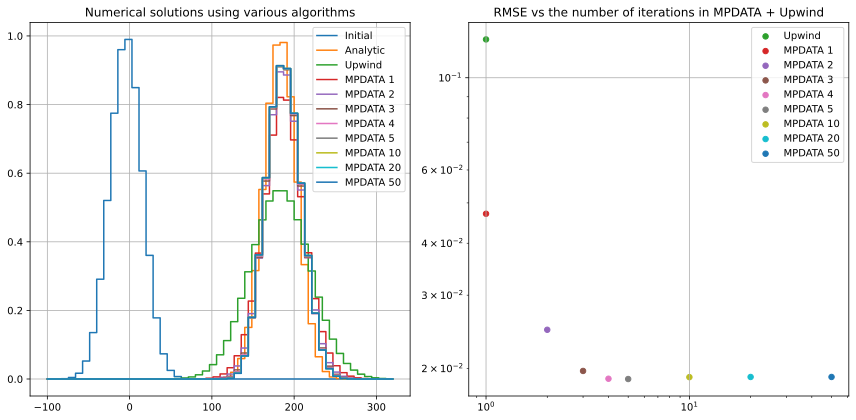

In [12]:
fig = plt.figure(figsize=(12, 6))
ax1, ax2 = fig.subplots(1, 2)

analytic_sol = ANALYTIC_SOLUTION(X, T_MAX)
upwind_sol = solve_upwind(nt=NT, c=C, psi=INITIAL_CONDITIONS(X))

ax1.step(X, INITIAL_CONDITIONS(X), label=f'Initial')
ax1.step(X, analytic_sol, label=f'Analytic')
line, = ax1.step(X, upwind_sol, label=f'Upwind')
ax2.scatter(1, rmse(upwind_sol, analytic_sol), label=f'Upwind', color=line.get_color(), s=30)

for mpdata_iter in (1, 2, 3, 4, 5, 10, 20, 50):
    mpdata_sol = solve_mpdata(nt=NT, c=C, psi=INITIAL_CONDITIONS(X), iterations=mpdata_iter)
    line, = ax1.step(X, mpdata_sol, label=f'MPDATA {mpdata_iter}', where='mid')
    ax2.scatter(mpdata_iter, rmse(mpdata_sol, analytic_sol), label=f'MPDATA {mpdata_iter}', color=line.get_color(), s=30)

ax1.set_title('Numerical solutions using various algorithms')
ax1.legend()
ax2.set_title('RMSE vs the number of iterations in MPDATA + Upwind')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend()

fig.tight_layout()

show_plot(fig=fig)

### Narrative explaining the results

Results concluded from the plots:

- We can observe significant error reduction both visually (left plot) and numerically (right plot) when using iterative MPDATA algorithm compared to a simple upwind scheme. The error further reduces when the number of iterations progresses, this suggests that the MPDATA algorithm iteration procedure was implemented successfully.
- On the right plot, we can see that the error drops sharply when the number of iterations is small. However, after around 10 iterations, the error rate stops decreasing, which is to be expected, because the MPDATA is only a second order numerical scheme.

As advised, this notebook is shorter :)